## Цель иследования
 - выявить частоту (периоды) повторяемости наблюдаемой характеристики 'rang_namber'
 - создать модель для ML позволяющую предиктить периоды на новых данных 
 - предположить факторы влияющие на чатсоту повторяемости
 - https://github.com/julianandrews/flopferret/blob/master/flopferret/board_texture.py

In [18]:
import re
import pandas as pd
from datetime import datetime
import eval7, pprint
from poker.room.pokerstars import PokerStarsHandHistory
from poker.hand import Hand, Combo
import numpy as np
from phevaluator import evaluate_cards
import matplotlib.pyplot as plt
plt.style.use('dark_background') #стиль графиков

In [97]:
# Создали словарь
data_pd = {'TypeOfRoom': [], 'HandId': [], 'Tournament': [], 'Level': [], 'Date': [], 'Hour': [],
           'TimeZoneAbb': [], 'Table': [], 'NoOfPlayers': [], 'bain': [], 'HandHiro': [], 'Board': []}

# Открываем файл
with open('dim1000.txt', 'r') as f: #Poker_\SNG dimetruk 1-54133.txt
    data = f.read()
    
# Ищем нужные данные
result = re.findall('(\w+) Hand #(\d*): Tournament #(\d*),(.*) Level (.*) - (\d{4}/\d+/\d+) (\d+\D\d+\D\d+) (\w*)', data)
Tables = re.findall('Table \'.*\' (.*) Seat .*\n', data)
bains = re.findall('(\D\d+\.\d+\+\D\d+\.\d+)', data)
HandHiros = re.findall("Dealt to dimetruk \D(.. ..)\D", data)
Boards = re.findall("Board \[(.*)\]", data)


# Считаем сколко фишек
s = re.findall('Seat (\d).*chips', data)
s = [int(x) for x in s]
seats = []
length = 1
for i in range(len(s)-1):
    if s[i+1] < s[i]:
        seats.append(length)
        length = 1
    else:
        length += 1
seats.append(length)


# ЗАполнЯем словарь данными
for r, table, bain, seat, handHiro, board in zip(result, Tables, bains, seats, HandHiros, Boards):
    data_pd['TypeOfRoom'].append(r[0])
    data_pd['HandId'].append(r[1])
    data_pd['Tournament'].append(r[2])
    # data_pd['info'].append(r[3])
    data_pd['Level'].append(r[4])
    data_pd['Date'].append(r[5])
    data_pd['Hour'].append(r[6])
    data_pd['TimeZoneAbb'].append(r[7])
    data_pd['Table'].append(table) #table
    data_pd['NoOfPlayers'].append(seat)
    data_pd['bain'].append(bain)
    data_pd['HandHiro'].append(handHiro)
    data_pd['Board'].append(board)

# Создаём ДатаФрейм
dataf = pd.DataFrame(data_pd)
dataf.head()

,TypeOfRoom,HandId,Tournament,Level,Date,Hour,TimeZoneAbb,Table,NoOfPlayers,bain,HandHiro,Board
0,PokerStars,226484810600,3187437334,IV (40/80),2021/05/05,19:56:10,MSK,6-max,2,$13.79+$1.21,Jh Td,8h 8c 7c 3h 6d
1,PokerStars,226484828418,3187437334,V (60/120),2021/05/05,19:56:57,MSK,6-max,2,$13.79+$1.21,Ts 3s,2s 6s As Jc Th
2,PokerStars,226484843891,3187437334,V (60/120),2021/05/05,19:57:39,MSK,6-max,2,$13.79+$1.21,4s 5c,Ks Qh 7h Tc 4c
3,PokerStars,226484859594,3187437334,V (60/120),2021/05/05,19:58:21,MSK,6-max,2,$13.79+$1.21,9c Th,7s 4d Qd
4,PokerStars,226484865470,3187437334,V (60/120),2021/05/05,19:58:37,MSK,6-max,2,$13.79+$1.21,7h 9d,2h Qd 5d Ts 3s


## Преобразуем строковые данные

In [98]:
date = data_pd['Date']
time = data_pd['Hour']

dataf["Date"] = pd.to_datetime(data_pd['Date'])
dataf["Time"] = pd.to_timedelta(data_pd['Hour'])

dataf["DateTime"] = dataf["Date"] + dataf["Time"]
dataf["DateTime"]

dataf.Tournament = df.Tournament.astype('int64')
dataf = dataf.astype({'HandId': np.int64, 'Tournament': np.int64})

## Фильтруем турниры по числу рук выше среднего (mean * 2)

In [158]:
data_filter = dataf[['Tournament', 'HandId','DateTime', 'HandHiro', 'Board']]
data_filter.head()

,Tournament,HandId,DateTime,HandHiro,Board
0,3187437334,226484810600,2021-05-05 19:56:10,Jh Td,8h 8c 7c 3h 6d
1,3187437334,226484828418,2021-05-05 19:56:57,Ts 3s,2s 6s As Jc Th
2,3187437334,226484843891,2021-05-05 19:57:39,4s 5c,Ks Qh 7h Tc 4c
3,3187437334,226484859594,2021-05-05 19:58:21,9c Th,7s 4d Qd
4,3187437334,226484865470,2021-05-05 19:58:37,7h 9d,2h Qd 5d Ts 3s


In [159]:
data_filter.groupby(['Tournament']).agg({'HandId': "count"}).reset_index()

,Tournament,HandId
0,3187437334,25
1,3187445431,3
2,3187736508,18
3,3187738267,13
4,3187770419,8
5,3188052591,16
6,3188065522,10
7,3188077995,48
8,3188080898,4
9,3188088059,45


In [177]:
#  Фильтруйте value_counts с помощью isin  https://softhints.com/pandas-how-to-filter-results-of-value_counts/
# data_filter[data_filter['Tournament'].isin(data_filter['Tournament'].value_counts()[data_filter['Tournament'].value_counts()>30].index)].Tournament


In [173]:
#  Используйте group by и lambda для имитации фильтра для value_counts()
df = data_filter.groupby('Tournament').filter(lambda x: len(x) > (data_filter['Tournament'].value_counts().mean())*2)
df

,Tournament,HandId,DateTime,HandHiro,Board
93,3188077995,226511905133,2021-05-06 18:58:13,Js Jc,9c Qd 2h
94,3188077995,226511943630,2021-05-06 19:00:08,Ah Ks,4h Qd 2c 5s
95,3188077995,226511993603,2021-05-06 19:02:19,Qh Ad,4h Ts 9c Kc 4c
96,3188077995,226512030227,2021-05-06 19:03:43,Kd As,5s 6h Jc 3h
97,3188077995,226512227416,2021-05-06 19:10:37,Jc Ad,4d 7h Ah 5d Kh
...,...,...,...,...,...
974,3231914115,228379928522,2021-07-18 15:41:04,9d Ad,2h 3d Kc 8h 8s
975,3231914115,228379944646,2021-07-18 15:41:32,5h 4c,Jc 9d 6c 9s
976,3231914115,228379961865,2021-07-18 15:42:31,4c Tc,Ac 9s 6h
977,3231914115,228379965572,2021-07-18 15:42:44,As Jc,Td 8s Ks Ac 4d


In [175]:
df.Tournament.value_counts()

3188224941    76
3227159788    65
3190325009    54
3188077995    48
3188088059    45
3189227656    44
3231914115    40
Name: Tournament, dtype: int64

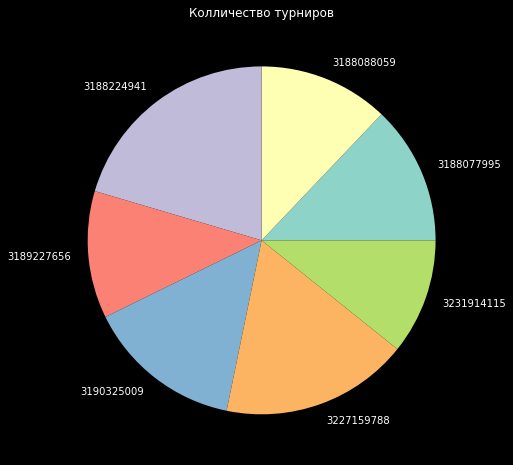

In [176]:
# Prepare Data
df_plot = df.groupby('Tournament').size()

# Make the plot with pandas
df_plot.plot(kind='pie', subplots=True, figsize=(8, 8))
plt.title("Колличество турниров")
plt.ylabel("")
plt.show()

In [178]:
# объеденяем руку и борд, выводим название комбинации

# df['hand'] = df['HandHiro'] + " " + df['Board']
# # hand = df['hand'].values[7].split()
# # print(hand)

# hand_ev = [eval7.Card(s) for s in (df['hand'].values[7].split())]
# rang = eval7.evaluate(hand_ev)   # ранг комбинации
# # print(rang)

# eval7s = eval7.handtype(rang)  #  название комбинации

# df['rang'] = eval7.evaluate(hand_ev)
# df['eval7s'] =  eval7.handtype(rang)

In [30]:
# def new_type(row):
#     if row.traffic_source.lower() in ('yandex', 'google'):
#         return 'organic'
#     elif row.traffic_source.lower() in ('paid', 'email'):
#         if row.region.lower() == 'russia':
#             return 'ad'
#         else:
#             return 'other'

In [31]:
# log['source_type'] = log.apply(new_type, axis = 1)
# log.head(12)

In [32]:
# log.loc[log.traffic_source.isin(['yandex', 'google']), 'traffic_type'] = 'organic' 

In [185]:
df['hand_rang'] = df['HandHiro'] + " " + df['Board']
df['hand_rang']

print(type(df['hand_rang']), type(df['hand_rang'].values[7].split()))
df['hand_rang'].values[0].split()

<class 'pandas.core.series.Series'> <class 'list'>


['Js', 'Jc', '9c', 'Qd', '2h']

In [186]:
# df['hand_rang'].to_list()
# df['hand_rang'].tolist()
# np.array(df['hand_rang'].tolist())
# Ls = list(df['hand_rang'])
ls = df['hand_rang'].str.split()
ls

93             [Js, Jc, 9c, Qd, 2h]
94         [Ah, Ks, 4h, Qd, 2c, 5s]
95     [Qh, Ad, 4h, Ts, 9c, Kc, 4c]
96         [Kd, As, 5s, 6h, Jc, 3h]
97     [Jc, Ad, 4d, 7h, Ah, 5d, Kh]
                   ...             
974    [9d, Ad, 2h, 3d, Kc, 8h, 8s]
975        [5h, 4c, Jc, 9d, 6c, 9s]
976            [4c, Tc, Ac, 9s, 6h]
977    [As, Jc, Td, 8s, Ks, Ac, 4d]
978    [3d, Kh, Js, 9s, Th, 9d, 8h]
Name: hand_rang, Length: 372, dtype: object

In [187]:
# напишем функцию получения ранг комбинации

def evaluate_(hand):
    """
    На вход получает карты, на выход 
    число ранг по eval7
    """
    hand_ev = [eval7.Card(s) for s in (hand)]
    return eval7.evaluate(hand_ev)

a = ('Jh', 'Td', '8h', '8c', '7c', '3h', '6d')
evaluate_(a)

17209424

In [188]:
# напишем функцию получения названия ранга

def handtype_(rang):
    """
    На вход получает ранг, на выход 
    название 
    """
    return eval7.handtype(rang)

handtype_(17209424)

'Pair'

In [189]:
# Применим функцию к столбцу hand  и запишем в новый столбец rang_namber

df['rang_namber'] = df['hand_rang'].str.split().apply(evaluate_)
df['handtypes'] = df['rang_namber'].apply(handtype_)
df[['rang_namber', 'handtypes']]
# df['filter'] = df.loc[df.handtypes.str.contains('Two Pair', 'Trips', 'Straight', 'Full House', 'Quads', 'Straight Flush'), 'rang_namber']

,rang_namber,handtypes
93,17409792,Pair
94,834098,High Card
95,16960416,Pair
96,833859,High Card
97,17611088,Pair
...,...,...
974,17222512,Pair
975,17273904,Pair
976,821058,High Card
977,17611136,Pair


In [191]:
df[['Tournament', 'HandId','DateTime',  'rang_namber', 'handtypes']].head(20)  # применим фильтер по столбцам

,Tournament,HandId,DateTime,rang_namber,handtypes
93,3188077995,226511905133,2021-05-06 18:58:13,17409792,Pair
94,3188077995,226511943630,2021-05-06 19:00:08,834098,High Card
95,3188077995,226511993603,2021-05-06 19:02:19,16960416,Pair
96,3188077995,226512030227,2021-05-06 19:03:43,833859,High Card
97,3188077995,226512227416,2021-05-06 19:10:37,17611088,Pair
98,3188077995,226512276903,2021-05-06 19:12:21,762913,High Card
99,3188077995,226512291156,2021-05-06 19:12:53,50776576,Trips
100,3188077995,226512384003,2021-05-06 19:16:23,17541232,Pair
101,3188077995,226512420306,2021-05-06 19:17:44,84702769,Flush
102,3188077995,226512443478,2021-05-06 19:18:37,17019904,Pair


In [195]:
df.handtypes.value_counts()

Pair          161
High Card     115
Two Pair       64
Straight       10
Trips           7
Flush           7
Full House      7
Quads           1
Name: handtypes, dtype: int64

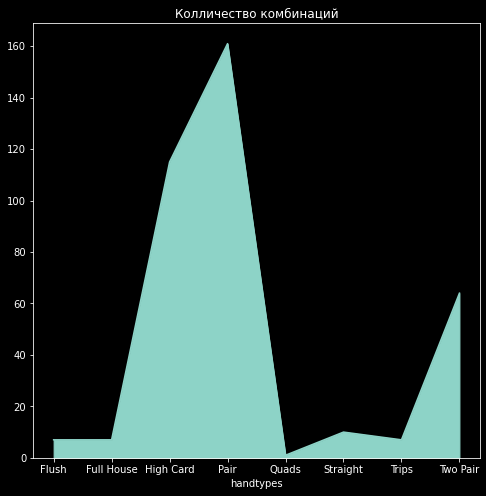

In [192]:
# Prepare Data
df_plot = df.groupby('handtypes').size()

# Make the plot with pandas
df_plot.plot(kind='area', subplots=True, figsize=(8, 8))
plt.title("Колличество комбинаций")
plt.ylabel("")
plt.show()

In [196]:
# df['DateTime'] = df['DateTime'][(df['DateTime'] > '2018-10-01 20:00:00') & (df['DateTime'] < '2022-10-02 00:00:00')]
# df['DateTime']


In [203]:
# отфильтруем комбинации "старшая карта" и "пара"
df['no_par'] = df['rang_namber'][df['rang_namber'] > 50000000] #[((df['rang_namber'] > 50000000) & (df['rang_namber'] < 60000000))]
# df = df.dropna()
df[['DateTime', 'no_par', 'handtypes']].head(10)
# df['filter_Two Pair'] = df['handtypes'][df['handtypes'] == 'Two Pair']
# df['filter_Two Pair']

,DateTime,no_par,handtypes
99,2021-05-06 19:12:53,50776576,Trips
101,2021-05-06 19:17:44,84702769,Flush
126,2021-05-06 19:37:12,67436544,Straight
157,2021-05-06 19:25:27,101105664,Full House
158,2021-05-06 19:28:36,67371008,Straight
164,2021-05-06 19:41:41,84579632,Flush
188,2021-05-06 20:06:07,84650065,Flush
199,2021-05-06 23:30:09,101466112,Full House
201,2021-05-06 23:35:07,51082752,Trips
209,2021-05-06 23:56:21,50580224,Trips


In [204]:
df.isnull().sum()

Tournament     0
HandId         0
DateTime       0
HandHiro       0
Board          0
hand           0
rang           0
eval7s         0
hand_rang      0
rang_namber    0
handtypes      0
filter         0
no_par         0
dtype: int64

In [43]:
# преобразуем время во временной ряд


In [59]:


idx = df['DateTime']
 # datetime.timedelta(seconds=24*60*60).total_seconds()

# second = df['DateTime'].dt.total_seconds()
# second

# idx = pd.date_range(df['DateTime'], periods=5, freq="H")
# idx
tim = pd.Series(range(len(idx)), index=idx)

# ts.resample("2H").mean()
tim

DateTime
2021-05-05 19:56:57      0
2021-05-05 19:59:58      1
2021-05-05 20:04:38      2
2021-05-05 20:01:52      3
2021-05-06 20:22:02      4
                      ... 
2021-07-18 15:12:21    101
2021-07-18 15:17:11    102
2021-08-05 01:00:11    103
2021-08-05 01:07:22    104
2021-08-05 01:16:14    105
Length: 106, dtype: int64

In [45]:
# # # idx = pd.date_range('2019-01-01', periods=48, freq='H')
# # x = pd.Series(range(len(idx)), index=idx)
# y = tim
# # add 'hour' and 'day' columns in the dataframe
# d = {'x': x, 'y': y, 'hour': idx.hour, 'day': idx.day}
# df = pd.DataFrame(data=d)
# # use 'hour' as x axis to plot, and 'day' as marker color
# df.plot.scatter(x='hour', y='y', c='day', colormap='rainbow')
# plt.show()

In [53]:
data.dtypes

DateTime    datetime64[ns]
filter               int64
dtype: object

In [54]:
# установитьdatetimeОбъект в качестве индекса кадра данных
data = data.set_index('DateTime')
data.head()

,filter
DateTime,
2021-05-05 19:56:57,84706320
2021-05-05 19:59:58,50968576
2021-05-05 20:04:38,84715347
2021-05-05 20:01:52,84715824
2021-05-06 20:22:02,67895296


<AxesSubplot:xlabel='DateTime'>

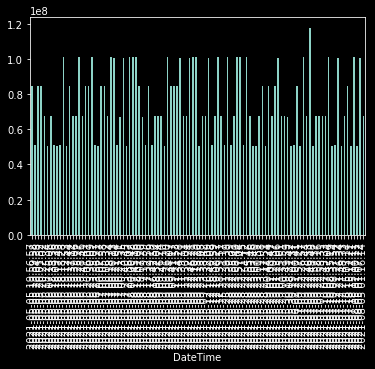

In [55]:

# data.plot(grid=True)

data['filter'].plot(kind='bar')

# import matplotlib.pyplot as plt
# from matplotlib.dates import DateFormatter
# # Группировка за месяц
# df_month = data.resample("M").mean()

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
# ax.bar(
#     df_month['2018':].index, 
#     df_month.loc['2016':, "filter"], 
#     width=25, align='center')

In [181]:

data.plot(kind='scatter', 
        x='DateTime', 
        y='filter', 
        title='Связь между жёсткостью воды и средней годовой смертностью')

AttributeError: 'str' object has no attribute 'plot'